In [7]:
!pip3 install s3fs


In [8]:
import numpy as np
import pandas as pd
from s3fs import S3FileSystem
import os


# s3a://airbnb-barcelona/
s3 = S3FileSystem()

In [16]:
cd ..

/Users/sgnipun.batra/developer/data_guild


In [17]:

import s3fs
import pyarrow.parquet as pq
import src.const as const

s3 = s3fs.S3FileSystem()

filePath = 's3://airbnb-barcelona/valid/currentDate=2020-03-13'
airbnb_df = pq.ParquetDataset(filePath, filesystem=s3).read_pandas().to_pandas()
airbnb = airbnb_df.drop(columns=const.dropped_columns)

In [20]:
import src.transform as trans
# drop outliers
airbnb = trans.drop_rows_occurs_less_than(airbnb, "cancellation_policy", 2)
airbnb = trans.drop_rows_occurs_less_than(airbnb, "neighbourhood_group_cleansed", 1)
airbnb = trans.drop_rows_occurs_less_than(airbnb, "host_response_time", 1)

# fillna
airbnb = airbnb.fillna(value={"host_is_superhost": False})
airbnb = airbnb.fillna(value={"host_has_profile_pic": False})
airbnb = airbnb.fillna(value={"host_identity_verified": False})
airbnb = airbnb.fillna(value={"host_response_time": "N/A"})

airbnb = trans.foldleft(trans.encode_boolean_to_float, airbnb, const.boolean_to_float_cols)

airbnb = airbnb.fillna(airbnb.mean())


[Text(0, 0, 'Eixample'),
 Text(0, 0, 'Ciutat Vella'),
 Text(0, 0, 'Sants-Montjuïc'),
 Text(0, 0, 'Sant Martí'),
 Text(0, 0, 'Gràcia'),
 Text(0, 0, 'Sarrià-Sant Gervasi'),
 Text(0, 0, 'Horta-Guinardó'),
 Text(0, 0, 'Les Corts'),
 Text(0, 0, 'Sant Andreu'),
 Text(0, 0, 'Nou Barris')]

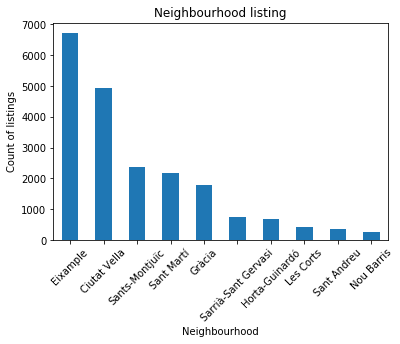

In [21]:
neighbourhood_group = airbnb["neighbourhood_group_cleansed"].value_counts()
viz_1 = neighbourhood_group.plot(kind='bar')
viz_1.set_title('Neighbourhood listing')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Neighbourhood')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

In [22]:
# category encode
category_encoder = trans.encode_category_dic(airbnb)
category_dic = trans.foldleft(category_encoder, {}, const.category_columns)
dic_host_response_time = {'host_response_time': {'N/A': 1, 'a few days or more': 2, 'within a day': 3, 'within a few hours': 4, 'within an hour': 5}}
category_dic = dict(dic_host_response_time, **category_dic)
airbnb = airbnb.replace(category_dic)

In [25]:
neDf = airbnb
neDf.head()

host_id  host_response_time  host_response_rate  host_is_superhost  \
0   71615                   5                0.99                0.0   
1   71615                   5                0.99                0.0   
2   90417                   5                1.00                1.0   
3  108310                   5                1.00                1.0   
4  136853                   5                0.92                0.0   

                                  host_verifications  host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'govern...                   1.0   
1  ['email', 'phone', 'reviews', 'jumio', 'govern...                   1.0   
2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                   1.0   
3  ['email', 'phone', 'reviews', 'jumio', 'offlin...                   1.0   
4  ['email', 'phone', 'facebook', 'reviews', 'jum...                   1.0   

   host_identity_verified  neighbourhood_group_cleansed  latitude  longitude  \
0                     1.0                             8  41.40889    2.18555   
1                     1.0                             2  41.40420    2.17306   
2                     1.0                             8  41.41203    2.22114   
3                     1.0                             3  41.40145    2.15645   
4                     0.0                             3  41.40950    2.15938   

   ...  review_scores_value  instant_bookable  cancellation_policy  \
0  ...                  8.0               0.0                    1   
1  ...                  9.0               1.0                    3   
2  ...                  9.0               1.0                    3   
3  ...                 10.0               1.0                    3   
4  ...                  9.0               1.0                    3   

   require_guest_profile_picture  require_guest_phone_verification  \
0                            0.0                               0.0   
1                            0.0                               0.0   
2                            0.0                               1.0   
3                            1.0                               1.0   
4                            0.0                               0.0   

   calculated_host_listings_count  \
0                            30.0   
1                            30.0   
2                             2.0   
3                             1.0   
4                            39.0   

   calculated_host_listings_count_entire_homes  \
0                                         30.0   
1                                         30.0   
2                                          2.0   
3                                          0.0   
4                                         39.0   

   calculated_host_listings_count_private_rooms  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           1.0   
4                                           0.0   

  calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                         0.0               0.02  
1                                         0.0               0.25  
2                                         0.0               0.48  
3                                         0.0               2.38  
4                                         0.0               1.71  

[5 rows x 43 columns]

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer


In [27]:
import re
def explode_string(source):
    source = re.sub('[\[\'\"\]]', '', source.strip())
    source = re.sub('\s', '', source.strip())
    source = re.sub('\'', '', source.strip())
    source = source.strip().split(",")
    return source


def explode_amenities(source):
    source = re.sub('[{}"]', '', source.strip())
    source = source.split(",")
    return source

In [28]:
lb1 = MultiLabelBinarizer()
lb_amenities = MultiLabelBinarizer()
lb1.fit([explode_string(x) for x in neDf['host_verifications'].values])
lb_amenities.fit([explode_amenities(x) for x in neDf['amenities'].values])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [29]:
lb_amenities.classes_

array(['', ' toilet', '24-hour check-in', 'Accessible-height bed',
       'Accessible-height toilet', 'Air conditioning', 'Air purifier',
       'Alfresco bathtub', 'Amazon Echo', 'BBQ grill', 'Baby bath',
       'Baby monitor', 'Babysitter recommendations', 'Balcony',
       'Bath towel', 'Bathroom essentials', 'Bathtub',
       'Bathtub with bath chair', 'Beach essentials', 'Beach view',
       'Beachfront', 'Bed linens', 'Bedroom comforts', 'Bidet',
       'Body soap', 'Breakfast', 'Breakfast table', 'Building staff',
       'Buzzer/wireless intercom', 'Cable TV', 'Carbon monoxide detector',
       'Cat(s)', 'Ceiling fan', 'Central air conditioning',
       'Changing table', 'Children’s books and toys',
       'Children’s dinnerware', 'Cleaning before checkout',
       'Coffee maker', 'Convection oven', 'Cooking basics', 'Crib',
       'DVD player', 'Day bed', 'Disabled parking spot',
       'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman',
       'Double oven', 'Dryer', '

In [30]:
lb1.classes_
lb1.transform([explode_string(x) for x in neDf['host_verifications'].values])[:,2:]

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [31]:
host_verifications_df = pd.DataFrame(lb1.transform([explode_string(x) for x in neDf['host_verifications'].values])[:,1:],
                          columns=lb1.classes_[1:],
                          index=neDf.index)
host_verifications_df.head()

None  email  facebook  google  government_id  identity_manual  jumio  kba  \
0     0      1         0       0              1                0      1    0   
1     0      1         0       0              1                0      1    0   
2     0      1         0       0              1                1      1    0   
3     0      1         0       0              1                1      1    0   
4     0      1         1       0              1                0      1    0   

   manual_offline  manual_online  ...  phone  photographer  reviews  selfie  \
0               0              0  ...      1             0        1       0   
1               0              0  ...      1             0        1       0   
2               0              0  ...      1             0        1       1   
3               0              0  ...      1             0        1       1   
4               0              0  ...      1             0        1       0   

   sent_id  sesame  sesame_offline  weibo  work_email  zhima_selfie  
0        0       0               0      0           0             0  
1        0       0               0      0           0             0  
2        0       0               0      0           0             0  
3        0       0               0      0           0             0  
4        0       0               0      0           1             0  

[5 rows x 21 columns]

In [32]:
amenities_df = pd.DataFrame(lb_amenities.transform([explode_amenities(x) for x in neDf['amenities'].values])[:,1:],
                          columns=lb_amenities.classes_[1:],
                          index=neDf.index)

In [33]:
encodedDF = neDf.join(host_verifications_df).join(amenities_df).drop(['amenities', 'host_verifications'], axis=1)

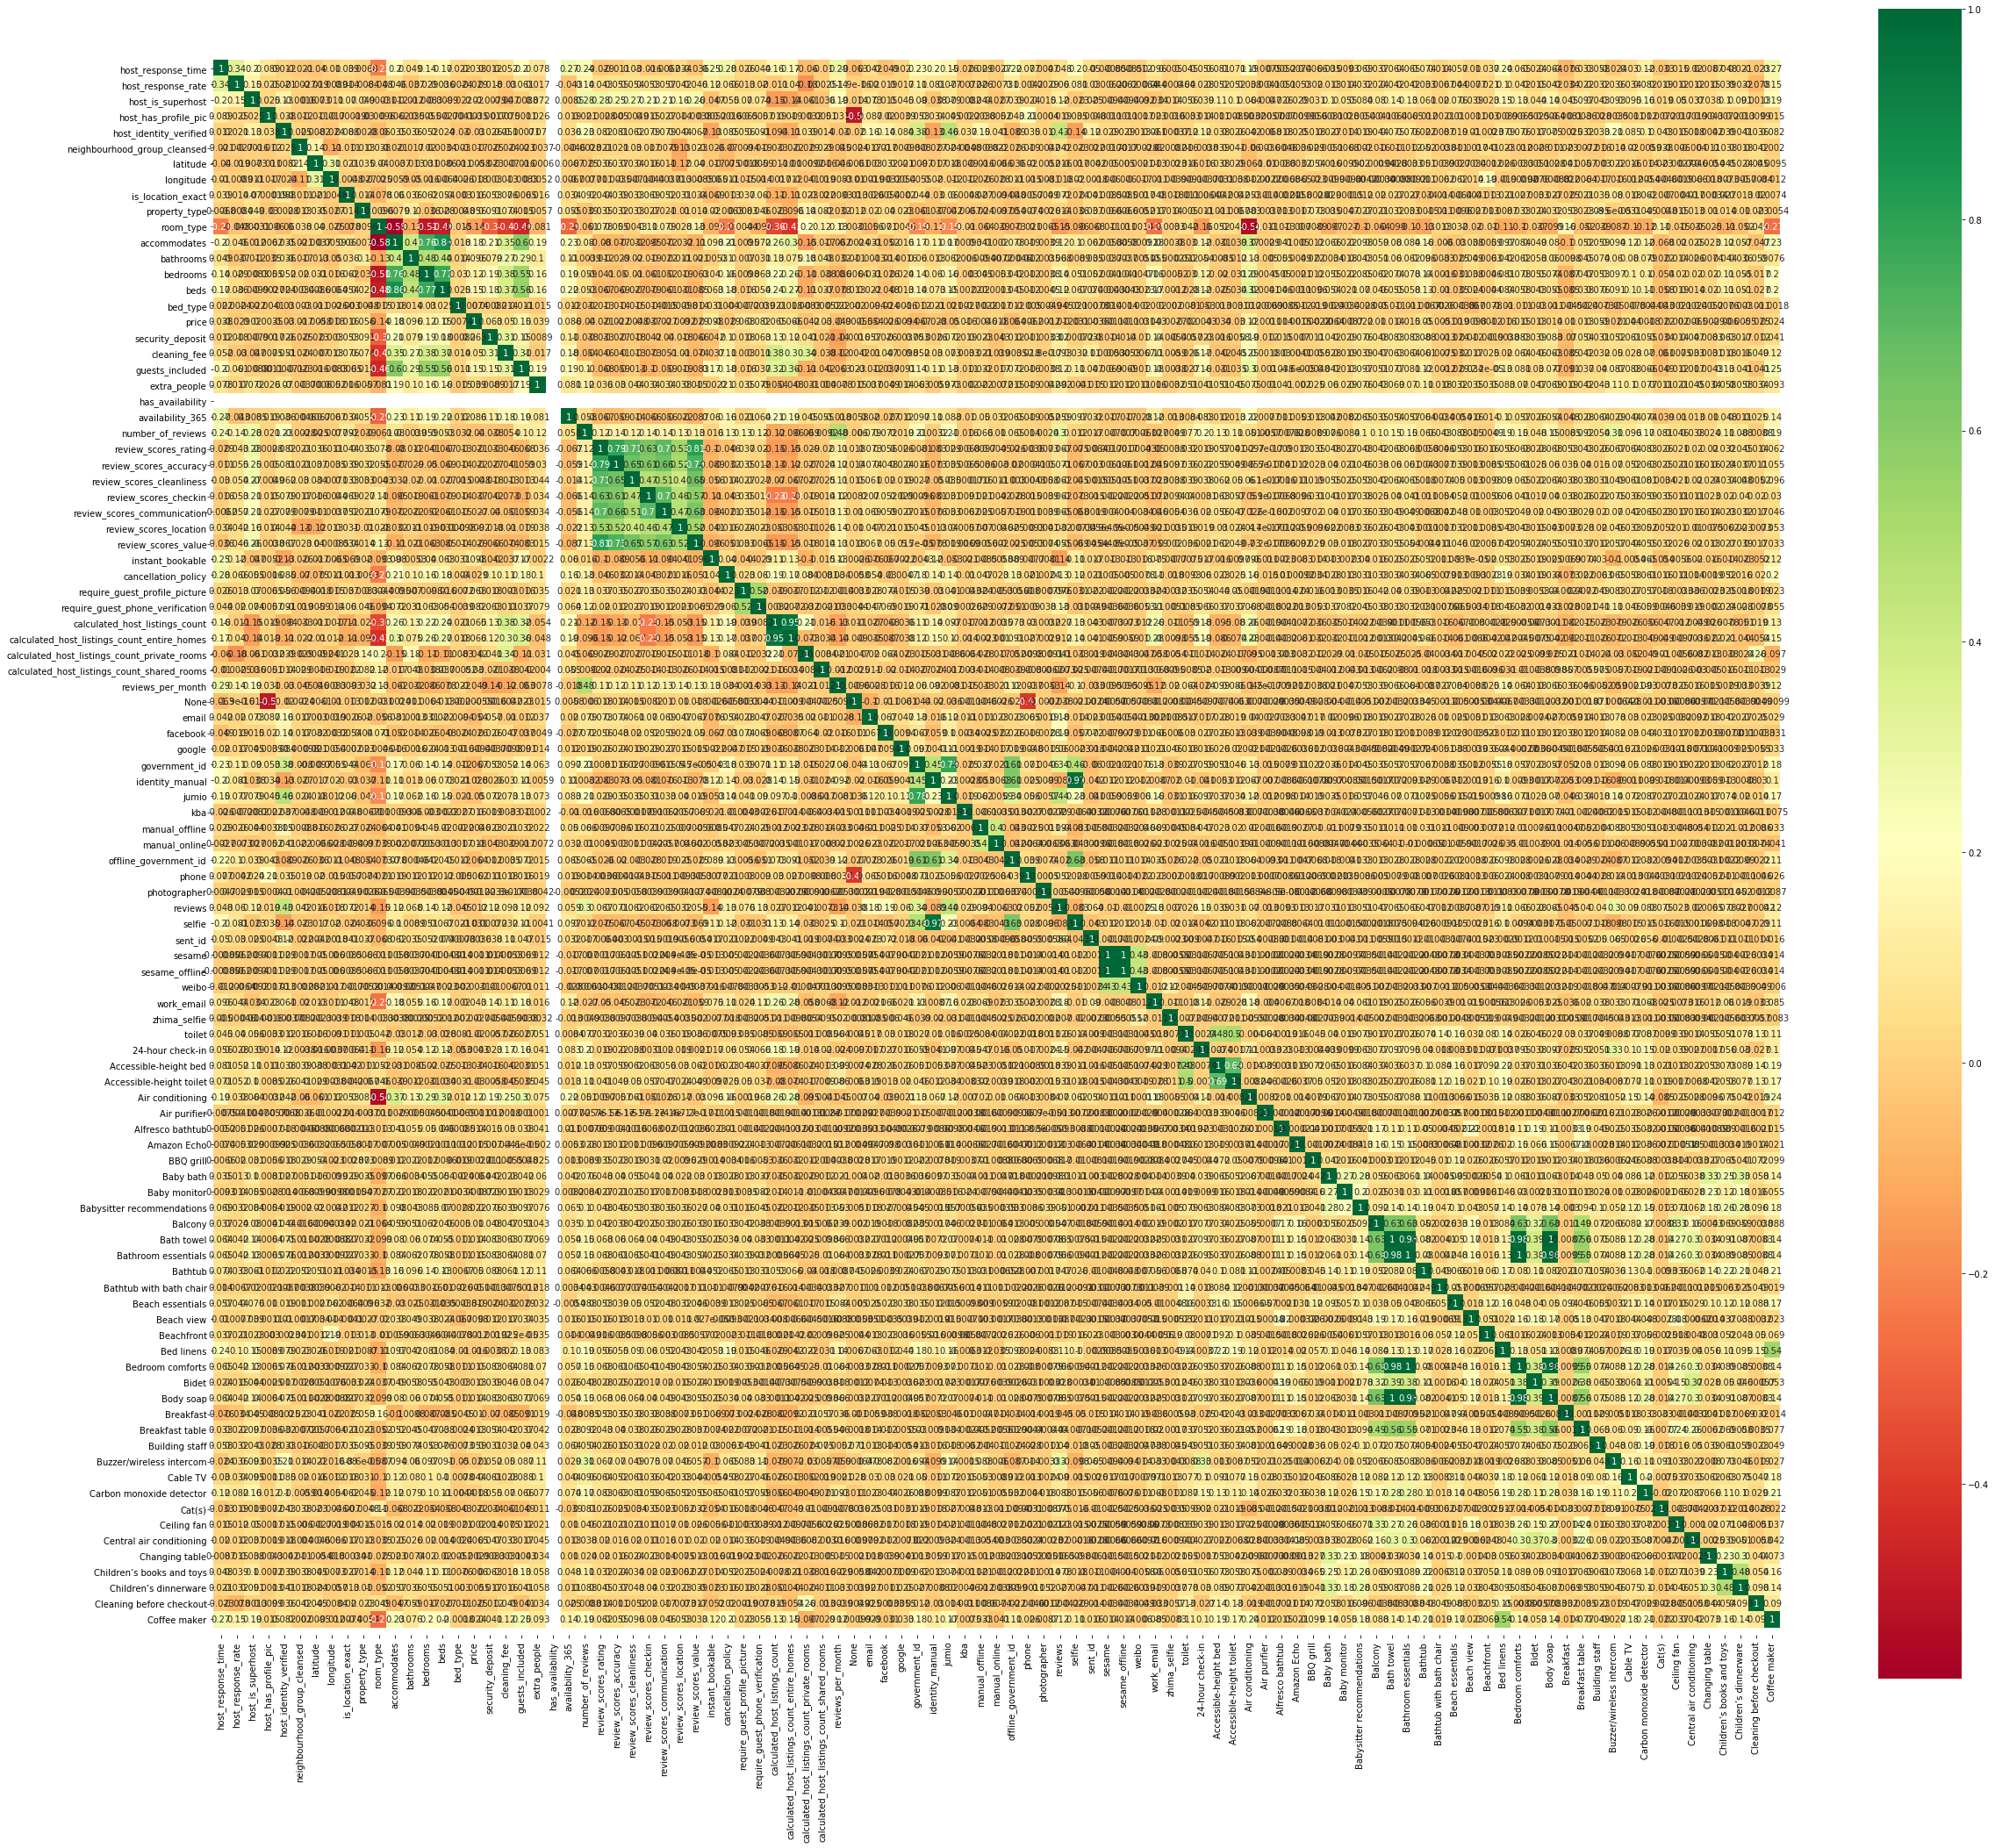

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, axes = plt.subplots(figsize=(40,35))
ax=sns.heatmap(encodedDF.iloc[:,0:100].corr(), annot=True, square=True, ax=axes, cmap='RdYlGn')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

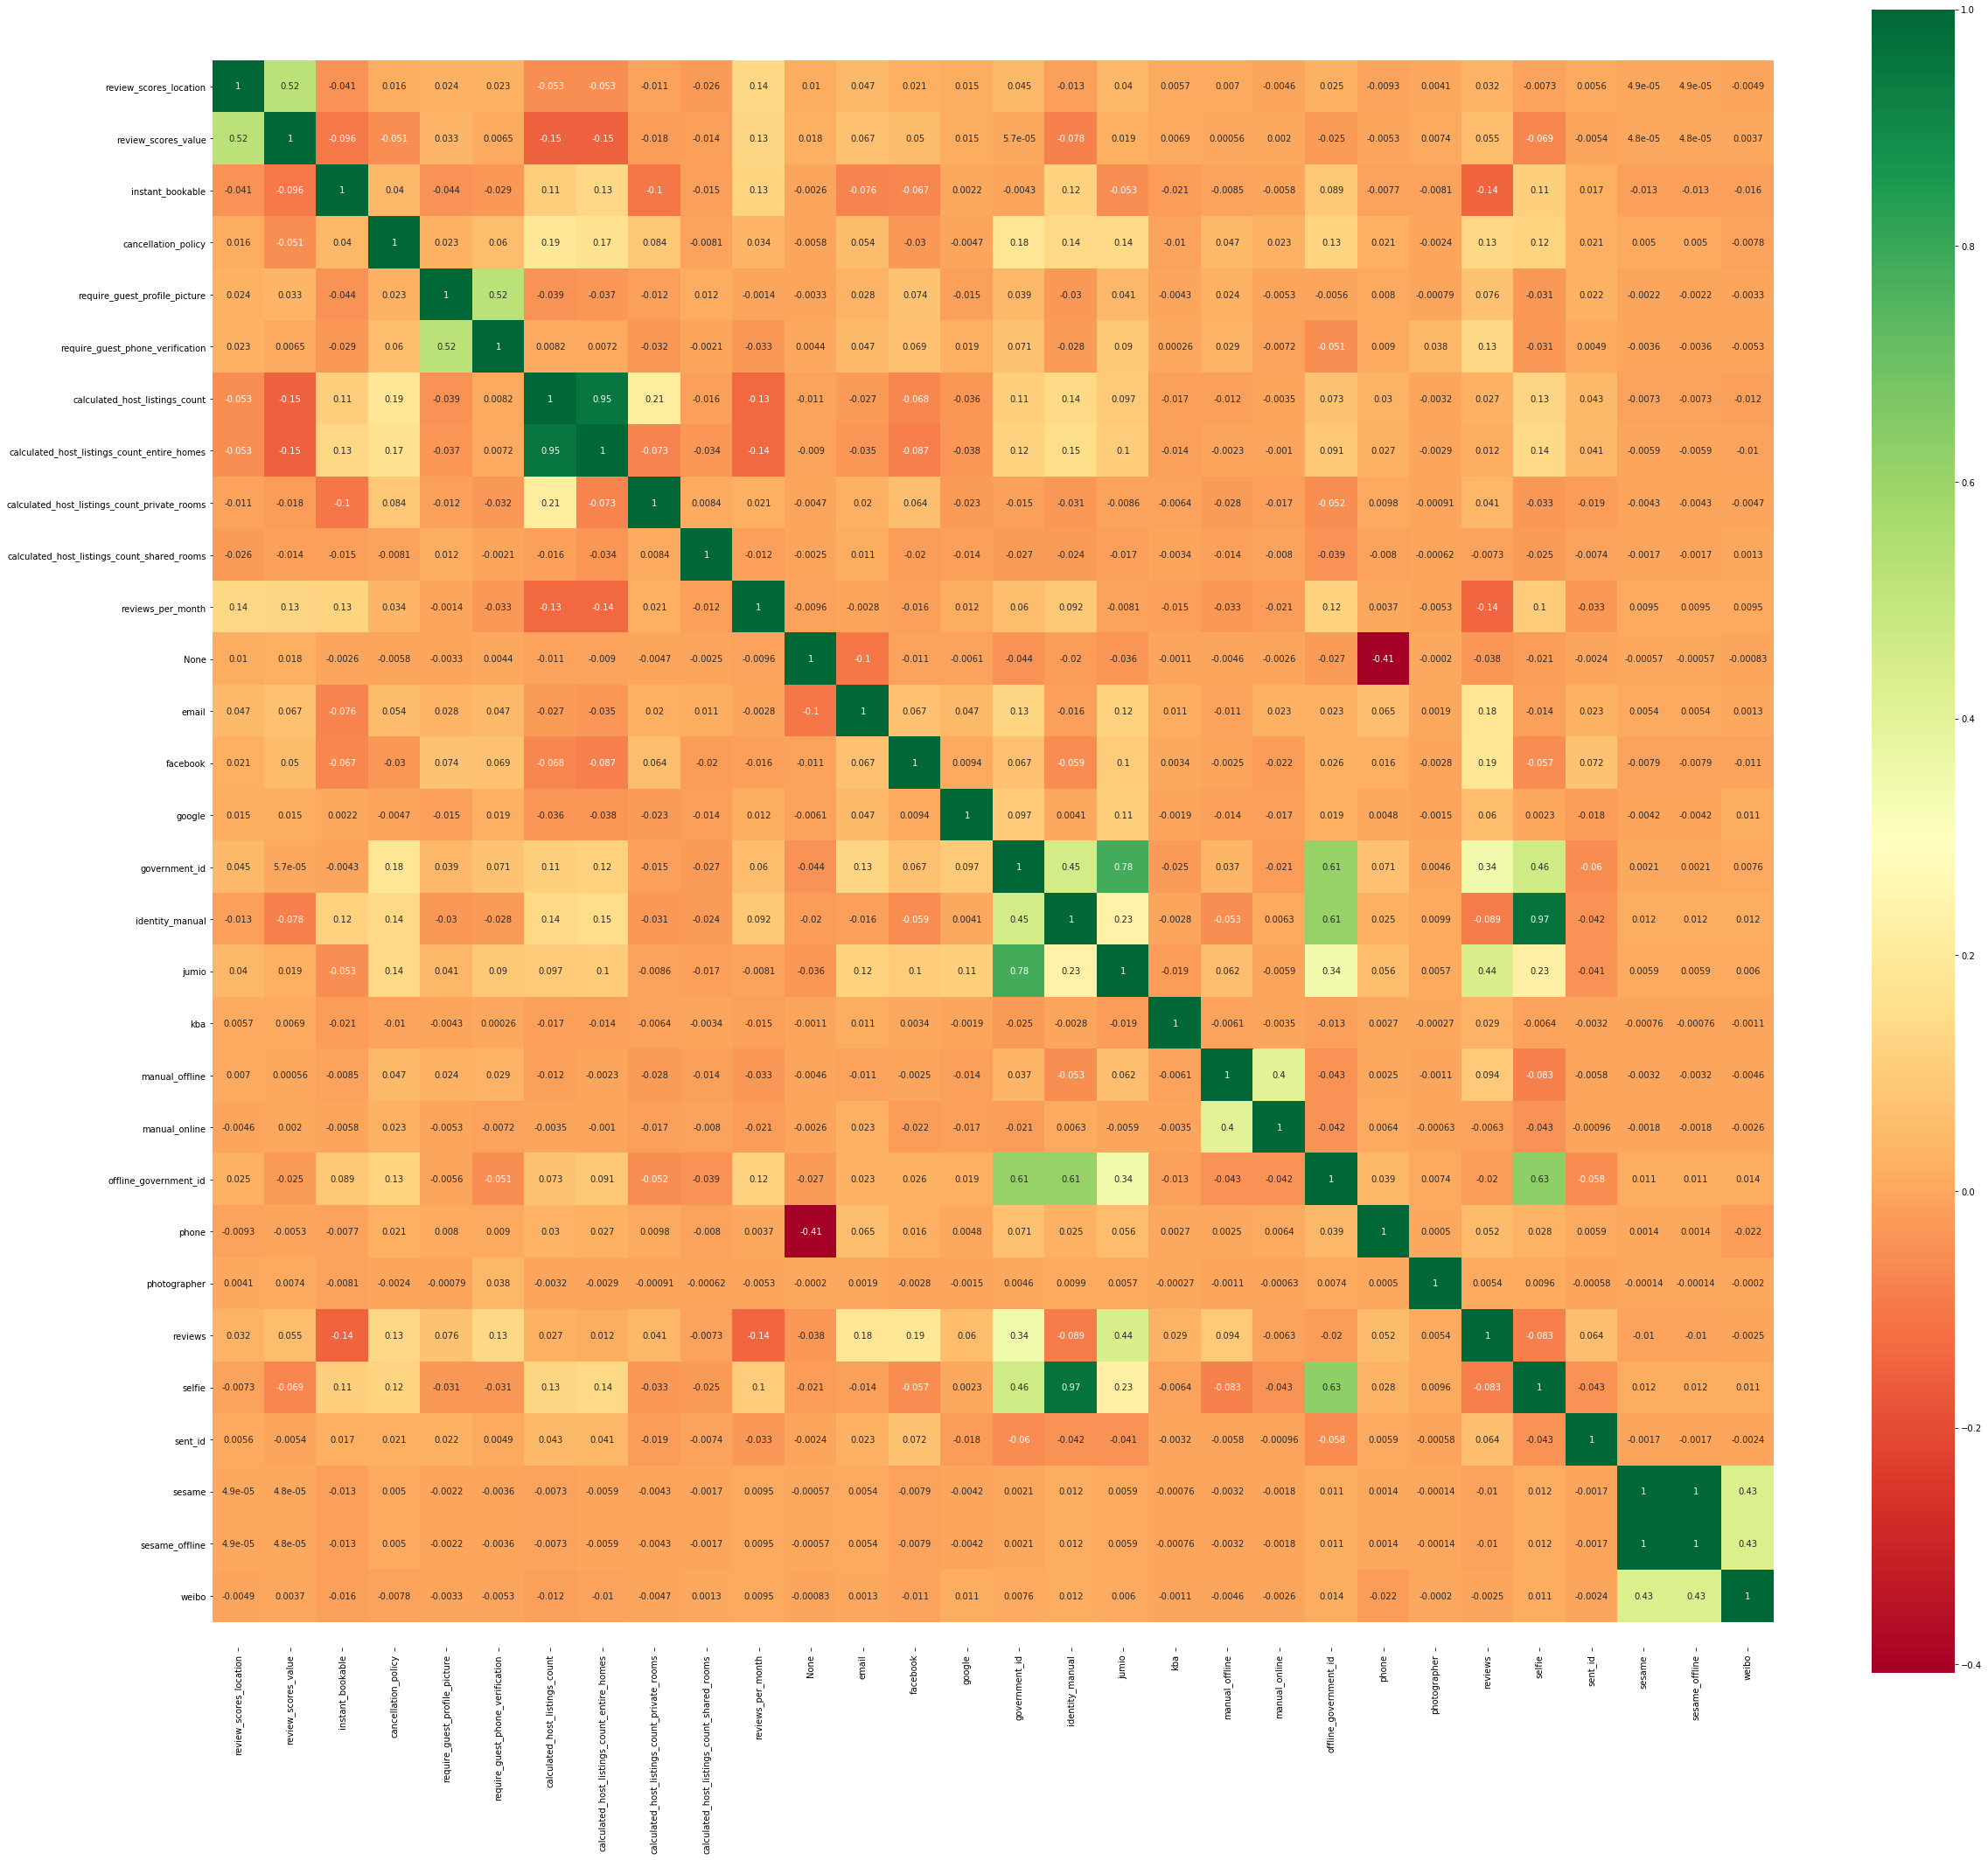

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(figsize=(40,35))
ax=sns.heatmap(encodedDF.iloc[:,30:60].corr(), annot=True, square=True, ax=axes, cmap='RdYlGn')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [36]:
y = encodedDF[['review_scores_value']]
X = encodedDF.drop(['review_scores_value'], axis=1)

In [37]:
encodedDF.head()

host_id  host_response_time  host_response_rate  host_is_superhost  \
0   71615                   5                0.99                0.0   
1   71615                   5                0.99                0.0   
2   90417                   5                1.00                1.0   
3  108310                   5                1.00                1.0   
4  136853                   5                0.92                0.0   

   host_has_profile_pic  host_identity_verified  neighbourhood_group_cleansed  \
0                   1.0                     1.0                             8   
1                   1.0                     1.0                             2   
2                   1.0                     1.0                             8   
3                   1.0                     1.0                             3   
4                   1.0                     0.0                             3   

   latitude  longitude  is_location_exact  ...  \
0  41.40889    2.18555                1.0  ...   
1  41.40420    2.17306                1.0  ...   
2  41.41203    2.22114                0.0  ...   
3  41.40145    2.15645                1.0  ...   
4  41.40950    2.15938                1.0  ...   

   Wide doorway to guest bathroom  Wide entrance  Wide entrance for guests  \
0                               0              0                         0   
1                               0              0                         0   
2                               0              0                         1   
3                               0              0                         0   
4                               0              0                         0   

   Wide entryway  Wide hallways  Wifi  Window guards  Wine cooler  \
0              0              0     1              0            0   
1              0              0     1              0            0   
2              1              1     1              0            0   
3              0              0     1              0            0   
4              0              0     1              0            0   

   translation missing: en.hosting_amenity_49  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   translation missing: en.hosting_amenity_50  
0                                           0  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 251 columns]

In [38]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

model=RandomForestRegressor()


X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, test_size=0.25)
params={}
grid_search=GridSearchCV(model, params, cv=5, scoring=('r2'), n_jobs=-1)
grid_search.fit(X_train, y_train)
ridge_best_model=grid_search.best_estimator_

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [39]:
rf_model = grid_search.best_estimator_

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y_predict = rf_model.predict(X_test)
r2 = r2_score(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)

In [41]:
mse

0.27386015297308125

In [42]:
r2

0.6659846481483516

In [46]:
lb_amenities.classes_

array(['', ' toilet', '24-hour check-in', 'Accessible-height bed',
       'Accessible-height toilet', 'Air conditioning', 'Air purifier',
       'Alfresco bathtub', 'Amazon Echo', 'BBQ grill', 'Baby bath',
       'Baby monitor', 'Babysitter recommendations', 'Balcony',
       'Bath towel', 'Bathroom essentials', 'Bathtub',
       'Bathtub with bath chair', 'Beach essentials', 'Beach view',
       'Beachfront', 'Bed linens', 'Bedroom comforts', 'Bidet',
       'Body soap', 'Breakfast', 'Breakfast table', 'Building staff',
       'Buzzer/wireless intercom', 'Cable TV', 'Carbon monoxide detector',
       'Cat(s)', 'Ceiling fan', 'Central air conditioning',
       'Changing table', 'Children’s books and toys',
       'Children’s dinnerware', 'Cleaning before checkout',
       'Coffee maker', 'Convection oven', 'Cooking basics', 'Crib',
       'DVD player', 'Day bed', 'Disabled parking spot',
       'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman',
       'Double oven', 'Dryer', '

In [48]:
import joblib

with s3.open('airbnb-barcelona/models/rnd_reg.reviews', 'wb') as f:
    joblib.dump(rf_model, f)
s3.du('airbnb-barcelona/models/rnd_reg.reviews')

with s3.open('airbnb-barcelona/models/rnd_reg.reviews', 'rb') as f:
    loaded_model = joblib.load(f)


expected:  review_scores_value    10.0
Name: 5939, dtype: float64
actual:  [9.74]


In [50]:
sample = X_test.iloc[9]
print("expected: ", y_test.iloc[9])
actual = loaded_model.predict([sample])
print('actual: ', actual)

expected:  review_scores_value    8.0
Name: 8428, dtype: float64
actual:  [8.4]
